## Import Data

In [1]:
import numpy as np
import imdb 
import pandas as pd
import random
from pandas.tools.plotting import autocorrelation_plot
from matplotlib import pyplot
#from error_generator import Explicit_Missing_Value
#from error_generator import Implicit_Missing_Value
#from error_generator import White_Noise
from error_generator import Gaussian_Noise
from error_generator import Random_Active_Domain
from error_generator import Similar_Based_Active_Domain
from error_generator import Typo_Keyboard
from error_generator import Typo_Butterfingers
from error_generator import Word2vec_Nearest_Neighbor
from error_generator import Value_Selector
from error_generator import List_selected
from error_generator import Read_Write
from error_generator import Error_Generator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

anime_data = pd.read_csv("../../new_anime_data1.csv", index_col=0)

anime_data['episodes'] = anime_data['episodes'].replace('Unknown', np.nan)


c:\users\larat\appdata\local\programs\python\python37-32\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Cleaning

In [2]:
l1 = []
l2 = []
l3 = []


anime_data['genre'].fillna('',  inplace=True)
anime_data['overview'].fillna('',  inplace=True)
anime_data['type'].fillna('',  inplace=True)
anime_data['episodes'].fillna(0,  inplace=True)
anime_data['rating'].fillna(0,  inplace=True)
for index, row in anime_data.iterrows():
    item = row['genre']
    if(pd.isnull(item)):
            item =""
    else:
        if isinstance(item, (list, tuple)):
            item = ','.join(item)
        else:
            item = item.replace(" ","")
            item = item.replace("[","")
            item = item.replace("]","")
            item = item.replace("'","")
    l1.append(item) 
      

for index, row in anime_data.iterrows():
    item = row['overview']
    if(pd.isnull(row['overview'])):
            item = ""
    else:
       # for item in anime_data['overview']:
            if isinstance(item, (list, tuple)):
                item = ','.join(item)
            else:
                item = item.replace("[","")
                item = item.replace("]","")
    l2.append(item) 

for index, row in anime_data.iterrows():
    item = row['type']
    if(pd.isnull(row['type'])):
        item = np.nan
    else:    
        if "movie" in item:
            item = "movie"
        else:
            item = "tv series"
    l3.append(item)

    
    
anime_data['genre'] = l1   
anime_data['overview'] = l2
anime_data['type'] = l3

#drop dublicate
anime_data.drop_duplicates(inplace = True)


## Sampling

In [3]:
anime_train, anime_test = train_test_split(anime_data, test_size=0.2)
anime_test.to_csv("testDataset.csv", index = False,
                  columns = ['anime_id', 'name','genre','type', 'episodes','rating', 'members', 'overview'])


## Generating Errors

### data range

In [4]:
original = anime_train
print("Range of members who vote for the anime data is [",original.members.min(),",", original.members.max(), "]")

Range of members who vote for the anime data is [ 20 , 893100 ]


In [5]:
sample = anime_train.members[0:1200]
print("sample of the data before adding Gaussian Noise")
print(sample[1:10])
mu, sigma = 0, 100000

noise = np.random.normal(mu, sigma, 1200)

signal = sample + noise

print("\nsample of the data after adding Gaussian Noise")
print(signal[0:10])
   
anime_train.members.update(signal)

anime_train.to_csv("dirtyTrainDataset.csv", index = False,
                  columns = ['anime_id', 'name','genre','type', 'episodes','rating', 'members', 'overview'])

sample of the data before adding Gaussian Noise
1392      16484
4829        625
7701        195
4352        967
12078       932
8922        168
923      174026
11170      6420
7163       1268
Name: members, dtype: int64

sample of the data after adding Gaussian Noise
12133     43039.587093
1392     137602.648002
4829      16884.130437
7701    -195661.062153
4352      -4233.527338
12078   -139149.759713
8922       7980.626174
923       53262.871075
11170     83074.943788
7163    -220927.152929
Name: members, dtype: float64


### Plot with Gaussian Noise

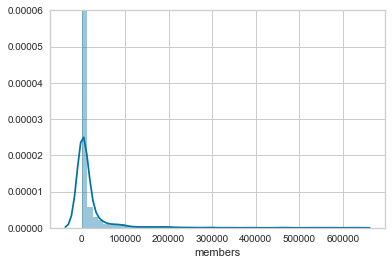

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Befor Applying Gaussian Noise
plt.ylim(0.0, 0.00006)
sns.distplot(sample)

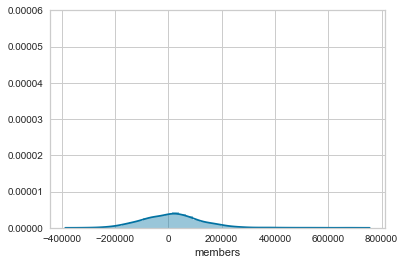

In [7]:
#After Applying Gaussian Noise
plt.ylim(0.0, 0.00006)
sns.distplot(signal)

### data range + Gaussian Noise

In [8]:
print("Range of members who vote for the anime data is [",anime_train.members.min(),",", anime_train.members.max(), "]")

Range of members who vote for the anime data is [ -305001.22839997796 , 893100.0 ]


## Transformation

In [9]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
def get_words(x):
    bagofwords=[]
    for i in x:
        if i[1]=='NN':
            bagofwords.append(i[0])
        elif i[1]=='NNS':
            bagofwords.append(i[0])
        elif i[1]=='NNP':
            bagofwords.append(i[0])
        elif i[1]=='NNPS':
            bagofwords.append(i[0])
        elif i[1]=='JJ':
            bagofwords.append(i[0])
        elif i[1]=='JJR':
            bagofwords.append(i[0])
        elif i[1]=='JJS':
            bagofwords.append(i[0])
        elif i[1]=='RB':
            bagofwords.append(i[0])
        elif i[1]=='RBR':
            bagofwords.append(i[0])
        elif i[1]=='RBS':
            bagofwords.append(i[0])
    return bagofwords

def clean_words(x):
    b=nltk.pos_tag(nltk.word_tokenize(x))
    result=get_words(b)
    return result

In [10]:
def get_dummies(train_data_set, test_data_set):
    train_dummies = train_data_set.genre.str.get_dummies(',')
    test_dummies = test_data_set.genre.str.get_dummies(',')
    
    #print("Train Dummies",train_dummies.shape)    
    #print("Test Dummies",test_dummies.shape)
    
    #### ALİGN
    train_dummies, test_dummies = train_dummies.align(test_dummies, axis=1, join='left')
    
    test_dummies.fillna(0, inplace=True)
    
    type_lb = LabelBinarizer()
    fitted_type_lb = type_lb.fit(train_data_set.type.values)
    X_train = type_lb.transform(train_data_set.type.values)
    X_test  = type_lb.transform(test_data_set.type.values)
    
    dfOneHot_train = pd.DataFrame(X_train, columns = ["movie/TVseries" for i in range(X_train.shape[1])])
    dfOneHot_test  = pd.DataFrame(X_test,  columns = ["movie/TVseries" for i in range(X_test.shape[1])])
    
    
    train_data_set = pd.concat([train_data_set, dfOneHot_train], axis=1, join="inner")
    train_data_set = pd.concat([train_data_set, train_dummies ], axis=1, join="inner")

    test_data_set = pd.concat([test_data_set, dfOneHot_test], axis=1)
    test_data_set = pd.concat([test_data_set, test_dummies],  axis=1)
    
    test_data_set['movie/TVseries'].fillna(0, inplace=True)
    train_data_set['movie/TVseries'].fillna(0, inplace=True)

    return ([train_data_set, test_data_set])

def feature_transformation(train_data_set, test_data_set):
    
    dummieset = get_dummies(train_data_set, test_data_set)
    train_data_set = dummieset[0]
    test_data_set = dummieset[1]
        
    #Bag of Words
    summary_doc_train = train_data_set['overview'].fillna("").map(clean_words)
    summary_doc_train =summary_doc_train.apply(','.join)
    
    summary_doc_test = test_data_set['overview'].fillna("").map(clean_words)
    summary_doc_test =summary_doc_test.apply(','.join)
 
    vectorizer = TfidfVectorizer()
    fitted_vectorizer = vectorizer.fit(summary_doc_train)
    overview_feature_train = fitted_vectorizer.transform(summary_doc_train).toarray()
    overview_feature_test = fitted_vectorizer.transform(summary_doc_test).toarray()

    df_train = pd.DataFrame(overview_feature_train, columns = ["word"+ str(int(i)) for i in range(overview_feature_train.shape[1])])
    train_data_set = pd.concat([train_data_set, df_train], axis=1)
    
    df_test = pd.DataFrame(overview_feature_test, columns = ["word"+ str(int(i)) for i in range(overview_feature_test.shape[1])])
    test_data_set = pd.concat([test_data_set, df_test], axis=1)
    
    train_data_set = train_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    test_data_set = test_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    
    #drop NaN values
    train_data_set.dropna(inplace=True)
    test_data_set.dropna(inplace=True)
    
    train_data_set.fillna(0, inplace=True)
    test_data_set.fillna(0, inplace=True)
    
    return ([train_data_set, test_data_set])



In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

transformed_features = feature_transformation(anime_train, anime_test)

anime_train = transformed_features[0]
anime_test = transformed_features[1]

In [12]:
#anime_train = anime_train.dropna()
print(anime_train.shape)
print(anime_test.shape)

(27, 2274)
(26, 2274)


In [13]:
anime_y_train = anime_train['rating']
anime_X_train = anime_train.drop(columns=['rating'])

anime_y_test = anime_test['rating']
anime_X_test = anime_test.drop(columns=['rating'])


## Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(score_func=f_regression,k=700)
features = selector.fit(anime_X_train, anime_y_train)

# summarize scores
np.set_printoptions(precision=3)
#print(fit.scores_)

print(anime_X_train.shape)
print(anime_X_test.shape)
anime_X_train = features.transform(anime_X_train)
anime_X_test = features.transform(anime_X_test)
print(anime_X_train.shape)
print(anime_X_test.shape)

scaler = StandardScaler() 

# Apply transform to both the training set and the test set.
anime_X_train = scaler.fit_transform(anime_X_train)  
anime_X_test = scaler.transform(anime_X_test) 

(27, 2273)
(26, 2273)
(27, 700)
(26, 700)


## Training - Testing - Evaluation

In [15]:
def training(model, dataset, label):
    clf = model
    clf.fit(dataset, label)
    return clf

def testing_evaluation(model, testset):
    # Make predictions using the testing set
    anime_y_pred = model.predict(testset)

    # The mean absolute error
    print("Mean absolute error: %.2f" % np.sqrt(mean_absolute_error(anime_y_test, anime_y_pred)))

    # The mean squared error
    print("Mean squared error: %.2f" % np.sqrt(mean_squared_error(anime_y_test, anime_y_pred)))

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(anime_y_test, anime_y_pred))

### Linear Regression

In [16]:
clf = training(model = linear_model.LinearRegression(), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)

Mean absolute error: 0.64
Mean squared error: 0.47
Variance score: -2.39


### Lesso Regression

In [17]:
clf = training(model = linear_model.Lasso(), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)

Mean absolute error: 0.61
Mean squared error: 0.42
Variance score: -1.70


### LassoCV

In [18]:
'''
# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 100)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas, cv = 5)
visualizer = AlphaSelection(model)

visualizer.fit(anime_X_train, anime_y_train)
g = visualizer.poof()
'''


'\n# Create a list of alphas to cross-validate against\nalphas = np.logspace(-10, 1, 100)\n\n# Instantiate the linear model and visualizer\nmodel = LassoCV(alphas=alphas, cv = 5)\nvisualizer = AlphaSelection(model)\n\nvisualizer.fit(anime_X_train, anime_y_train)\ng = visualizer.poof()\n'

### Cross Validation

In [19]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
scores = cross_val_score(clf, anime_X_train, anime_y_train, scoring="neg_mean_squared_error", cv=5) 
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [0.472 0.058 0.15  0.182 0.221]
Mean: 0.21636581993906895
Standard deviation: 0.138486697354483


### Grid Search For Hyper Parameter Selection

In [20]:
def checkHP(model, folds, dataset, label):
    parameters = {
                    "alpha" : [1,0.1,0.01,0.001,0.0001,0]
                  }

    gd_sr = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring="neg_mean_squared_error",
                         cv=folds)

    gd_sr.fit(dataset, label)  
    
    best_parameters = gd_sr.best_params_  
    print("best parameters are: ", best_parameters)

    best_result = gd_sr.best_score_  
    print("The mean squared Error is: %.2f" % -best_result) 
    
checkHP(clf, 5, anime_X_train, anime_y_train) 

best parameters are:  {'alpha': 0.1}
The mean squared Error is: 0.07


### Retraining

In [21]:
clf = training(model = linear_model.Lasso(alpha = 0.1), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)

Mean absolute error: 0.61
Mean squared error: 0.44
Variance score: -1.88


### Evaluation the repairing of different methods on different amount of error in the data

### Drop

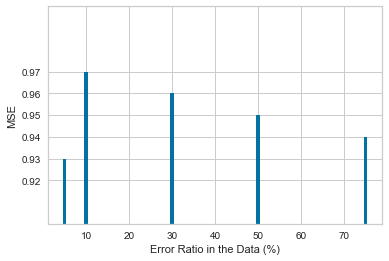

In [22]:
plt.xlabel('Error Ratio in the Data (%)')
plt.ylabel('MSE')

plt.ylim(0.90, 1)
plt.bar([5, 10, 30, 50, 75], [0.93, 0.97, 0.96, 0.95, 0.94])
plt.yticks([0.93, 0.97, 0.96, 0.95, 0.94, 0.92])
plt.show()

### Replace Negative values with Positive ones

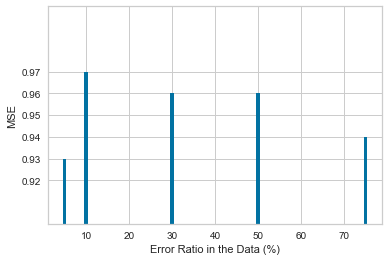

In [23]:
plt.xlabel('Error Ratio in the Data (%)')
plt.ylabel('MSE')
plt.ylim(0.90, 1)
plt.bar([5, 10, 30, 50, 75], [0.93, 0.97, 0.96, 0.96, 0.94])
plt.yticks([0.93, 0.97, 0.95, 0.96, 0.94, 0.92])
plt.show()

### Replace Negative values with the mean

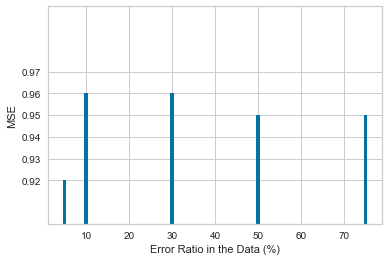

In [24]:
plt.xlabel('Error Ratio in the Data (%)')
plt.ylabel('MSE')
plt.ylim(0.90, 1)
plt.bar([5, 10, 30, 50, 75], [0.92, 0.96, 0.96, 0.95, 0.95])
plt.yticks([0.93, 0.97, 0.96, 0.95, 0.94,0.92])
plt.show()

### Replace with zero

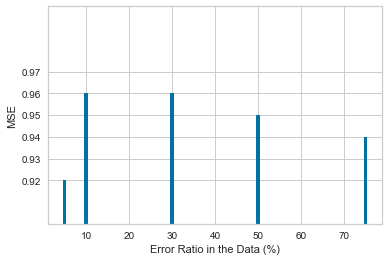

In [25]:
plt.xlabel('Error Ratio in the Data (%)')
plt.ylabel('MSE')
plt.ylim(0.90, 1)
plt.bar([5, 10, 30, 50, 75], [0.92, 0.96, 0.96, 0.95, 0.94])
plt.yticks([0.93, 0.97, 0.96, 0.95, 0.94,0.92])
plt.show()

### Filter

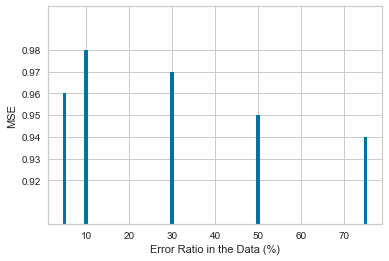

In [26]:
plt.xlabel('Error Ratio in the Data (%)')
plt.ylabel('MSE')

plt.ylim(0.90, 1)
plt.bar([5, 10, 30, 50, 75], [0.96, 0.98, 0.97, 0.95, 0.94])
plt.yticks([0.93, 0.97, 0.96, 0.95, 0.94,0.92,0.98])
plt.show()